In [1]:
import pickle
# Check epoch info 
"""with open('epoch/Unet_epoch.pk', 'rb') as f:
    Unet_epoch = pickle.load(f)
with open('epoch/Unet_lr.pk', 'rb') as f:
    Unet_lr = pickle.load(f)
print(Unet_epoch, Unet_lr)"""

"with open('epoch/Unet_epoch.pk', 'rb') as f:\n    Unet_epoch = pickle.load(f)\nwith open('epoch/Unet_lr.pk', 'rb') as f:\n    Unet_lr = pickle.load(f)\nprint(Unet_epoch, Unet_lr)"

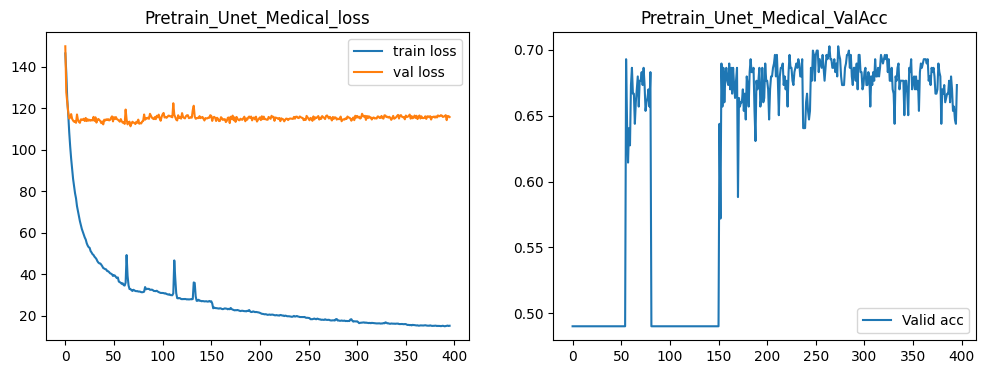

In [2]:
import pickle
import matplotlib.pyplot as plt

conformer = False
mix_image_mask = False
add_noise_ = False

if conformer:
    model_name = 'Conformer-Unet'
else:
    model_name = 'Unet'    
model_name = 'Pretrain_Unet_Medical'

if mix_image_mask:
    model_name += '-mix'
    add_times = 5
if add_noise_:
    model_name += '-noise'
    add_times = 5


with open(f'result/{model_name}_hist.pk', 'rb') as f:
    hist = pickle.load(f)
loss_train = hist['loss train']
loss_val = hist['loss val']
acc_val = hist['acc val']

plt.figure(figsize=(12, 4))
plt.subplot(1,2,1)
plt.plot(loss_train, label='train loss')
plt.plot(loss_val, label='val loss')
plt.title(f'{model_name}_loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(acc_val, label='Valid acc')
plt.title(f'{model_name}_ValAcc')
plt.legend()

plt.savefig(f'result/{model_name}_loss_acc.png')

plt.show()


In [3]:
from torch.utils.data import Dataset, DataLoader
class Dataset_(Dataset):
    def __init__(self, data):
        self.img = data[0]  # Assuming 'data' is a list of tuples (images, labels)
        self.label = data[1]
        self.tumormask = data[2]

    def __len__(self):
        return len(self.img)

    def __getitem__(self, idx):
        return self.img[idx], self.label[idx], self.tumormask[idx]
    
with open('./temp/testdataset.pk', 'rb') as f:
    testset = pickle.load(f)
testloader = DataLoader(testset, batch_size=16, shuffle=False)

In [4]:
from model import *
import torch
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model_path = f'checkpoint/{model_name}_best_model.pt'
if model_name == 'Pretrain_Unet_Medical':
    model = Pretrain_Unet_Medical(3).to(device)
model.load_state_dict(torch.load(model_path))

Using cache found in /home/jacob/.cache/torch/hub/mateuszbuda_brain-segmentation-pytorch_master


<All keys matched successfully>

In [5]:
from torchvision.utils import save_image
from tqdm import tqdm
from util import *

with torch.no_grad():
    model.eval()
    pred_m_all, true_m_all = [], []
    loss_e_val = 0
    acc = 0
    for i, l, m in tqdm(testloader):
        i, l_one, m = process(i, l, m)    
        loss, pred_m, out = forward(model, i, l_one, m)
        loss_e_val += loss.item()
        pred_m_all.append(pred_m)
        true_m_all.append(m)
        acc += (torch.argmax(out, dim=1) == (l-1).reshape(-1)).sum().item()
        
    acc = acc/len(testloader.dataset)
print(acc)
pred_m_all, true_m_all = torch.cat(pred_m_all), torch.cat(true_m_all)
save_image(torch.cat([pred_m_all[:32], true_m_all[:32]], dim = 0), f'result/{model_name}_ground_prediction.png', nrow=8)


100%|██████████| 20/20 [00:03<00:00,  5.77it/s]


0.6710097719869706
